In [1]:
%reload_ext autoreload
%autoreload 2

import datetime as dt
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..\..')

from Crypto.lib.backtest_statistics import account_curve_statistics
from Crypto.lib.constants import COINBASE_CRYPTOS
from Crypto.lib.data import import_data

pd.options.mode.chained_assignment = None

In [2]:
close = import_data()
close = close.resample("D", label='right').last().ffill()

In [3]:
def compute_daily_pnl(signal, close, cost):
    close = close.reindex_like(signal)
    positions = (signal / close).ffill(limit=5)  # $-neutral
    notional = positions * close
    trades = positions.diff().fillna(0.0)
    costs = trades.abs() * close * cost
    
    pnl_raw = positions.shift() * close.diff()
    pnl_cost = pnl_raw - costs
    pnl_raw = pnl_raw.resample("D").sum().cumsum()
    pnl_cost = pnl_cost.resample("D").sum().cumsum()
    
    pnl_long_raw = positions.shift().where(positions.shift() > 0) * close.diff()
    pnl_short_raw = positions.shift().where(positions.shift() < 0) * close.diff()
    pnl_long_raw = pnl_long_raw.resample("D").sum().cumsum()
    pnl_short_raw = pnl_short_raw.resample("D").sum().cumsum()
    
    return {
        "pnl_raw": pnl_raw,
        "pnl_cost": pnl_cost,
        "notional": notional,
        "positions": positions,
        "costs": costs,
        "pnl_long_raw": pnl_long_raw,
        "pnl_short_raw": pnl_short_raw,
    }

In [12]:
def plot_simulation(markets, cost, compute_signal):
    weights = compute_signal(close)
    weights = weights.loc["2017":, markets]
    res = compute_daily_pnl(weights, close, cost)

    fig, axes = plt.subplots(1, 3, figsize=(30, 6))
    sr_all_raw = account_curve_statistics(res["pnl_raw"].sum(axis=1)).Sharpe
    sr_all_cost = account_curve_statistics(res["pnl_cost"].sum(axis=1)).Sharpe

    sr_raw = account_curve_statistics(res["pnl_raw"]).Sharpe
    sr_cost = account_curve_statistics(res["pnl_cost"]).Sharpe

    res["pnl_raw"].sum(axis=1).plot(ax=axes[0], label="Raw", title=f"All (SR: raw={sr_all_raw:.2f}, cost={sr_all_cost:.2f})");
    res["pnl_cost"].sum(axis=1).plot(ax=axes[0], label="Cost");
    axes[0].legend();

    sr_long_raw = account_curve_statistics(res["pnl_long_raw"].sum(axis=1)).Sharpe
    sr_short_raw = account_curve_statistics(res["pnl_short_raw"].sum(axis=1)).Sharpe

    res["pnl_long_raw"].sum(axis=1).plot(ax=axes[1], label="Longs", title=f"Long/Short Raw (SR: longs={sr_long_raw:.2f}, shorts={sr_short_raw:.2f})");
    res["pnl_short_raw"].sum(axis=1).plot(ax=axes[1], label="Shorts");
    axes[1].legend();

    res["pnl_raw"].columns = [f"{x} (SR:{sr_raw.loc[x]:.1f})" for x in res["pnl_raw"].columns]
    res["pnl_raw"].plot(ax=axes[2], title="Per coin");

# Dollar neutral

..\..\Crypto\lib\backtest_statistics.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(DAYS_IN_YEAR) * mean / std


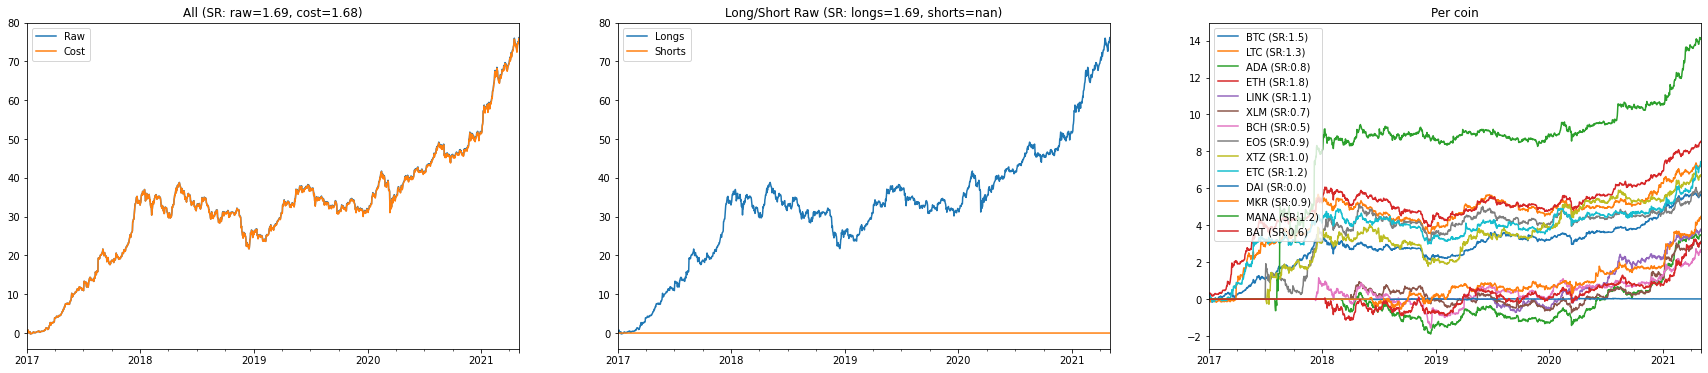

In [13]:
markets = COINBASE_CRYPTOS
cost = 0.0003

compute_signal = lambda close: close * 0 + 1
plot_simulation(markets, cost, compute_signal)

..\..\Crypto\lib\backtest_statistics.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(DAYS_IN_YEAR) * mean / std


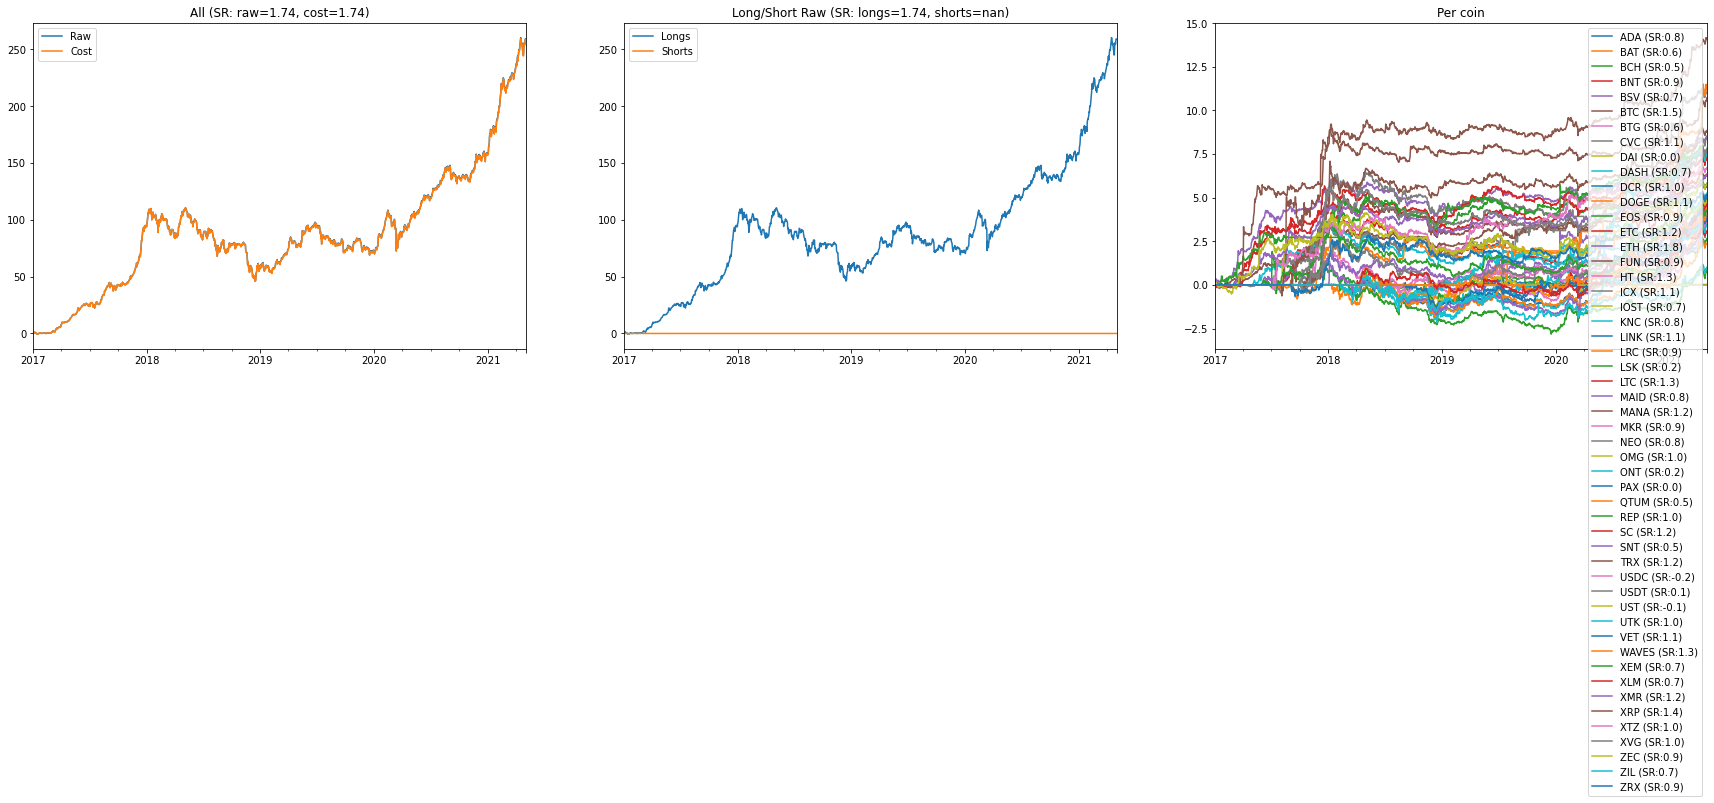

In [28]:
markets = close.columns
cost = 0.0003

compute_signal = lambda close: close * 0 + 1
plot_simulation(markets, cost, compute_signal)

# Risk parity

..\..\Crypto\lib\backtest_statistics.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(DAYS_IN_YEAR) * mean / std


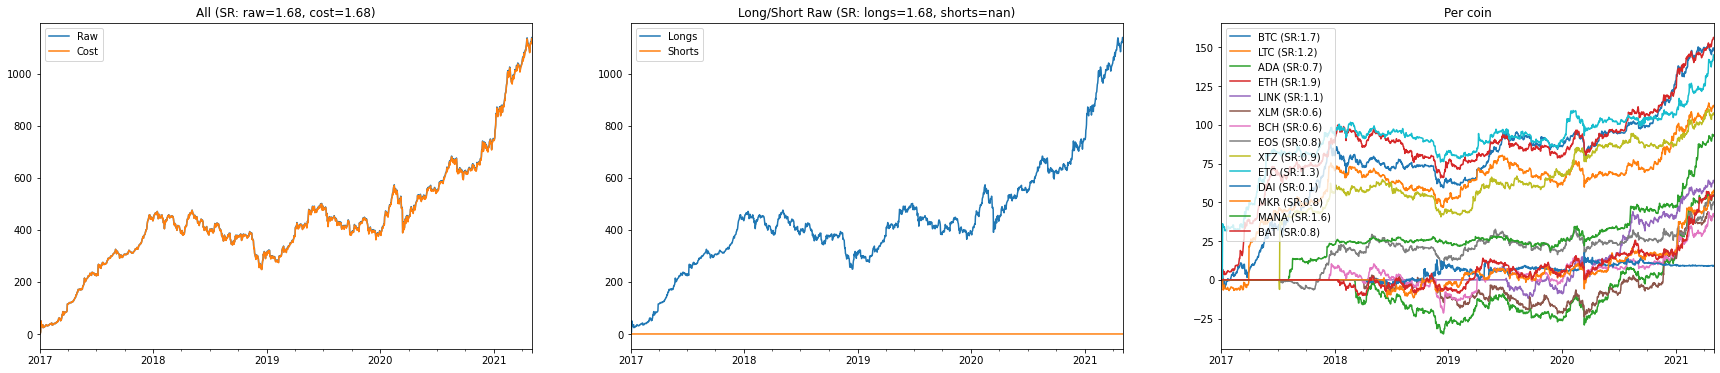

In [29]:
markets = COINBASE_CRYPTOS
cost = 0.0003

compute_signal = lambda close: 1 / close.pct_change().ewm(256).std()
plot_simulation(markets, cost, compute_signal)

..\..\Crypto\lib\backtest_statistics.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(DAYS_IN_YEAR) * mean / std


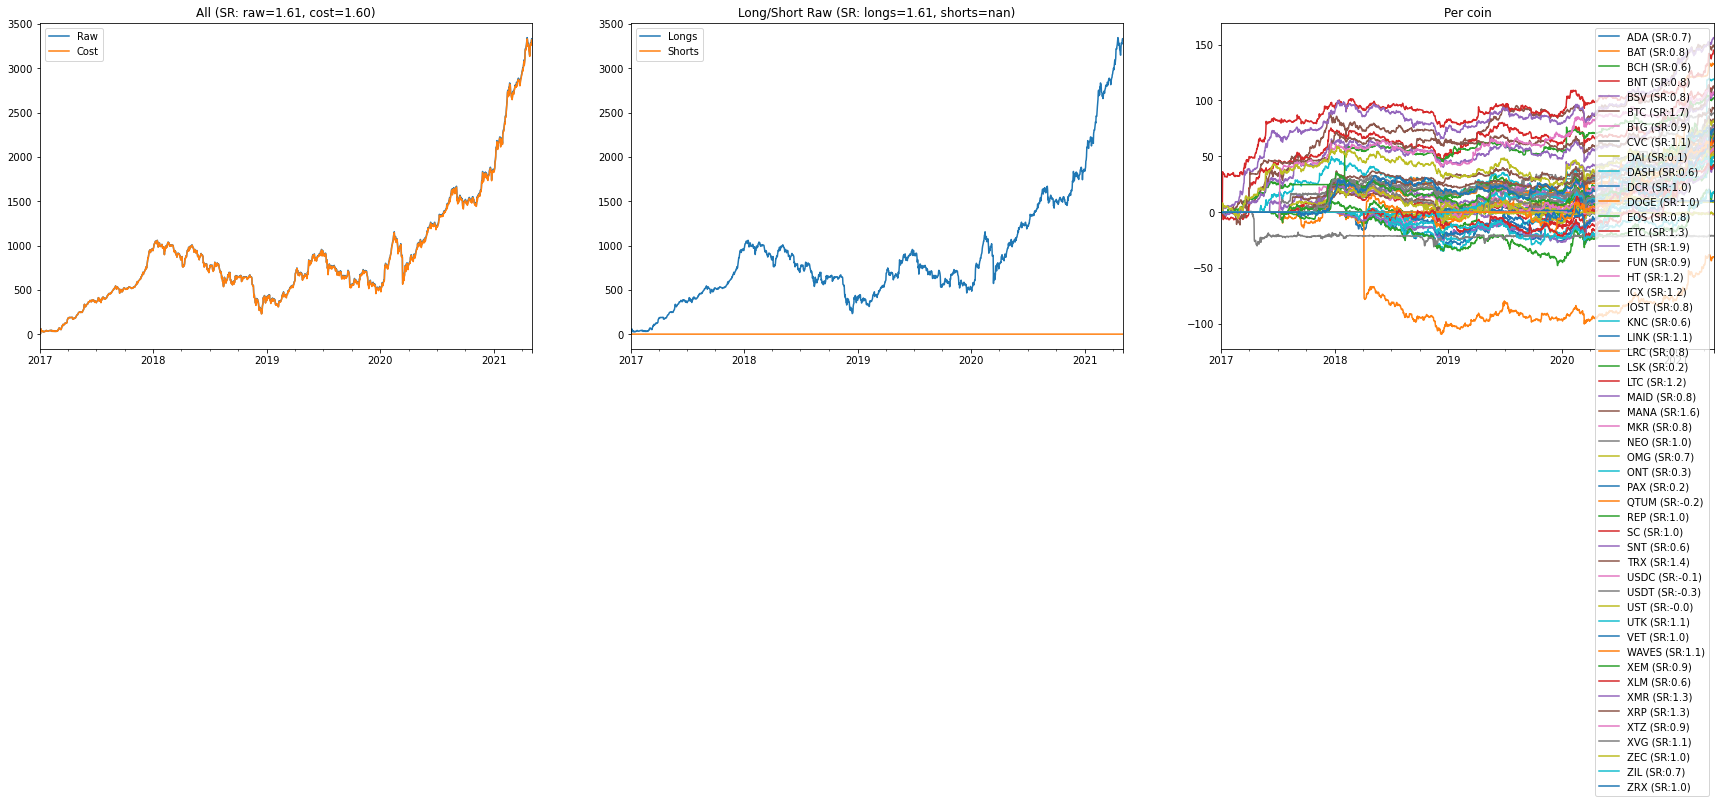

In [30]:
markets = close.columns
cost = 0.0003

compute_signal = lambda close: 1 / close.pct_change().ewm(256).std()
plot_simulation(markets, cost, compute_signal)